In [21]:
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.sparse as sparse
from bs4 import BeautifulSoup
import sys, os
from multiprocessing import Pool, cpu_count
from concurrent.futures import ThreadPoolExecutor,as_completed
from functools import partial
import collections
import urllib.request
import fiona
import rasterio.mask
import rasterio
import requests
import gzip
import pprint
import logging
import click
import itertools
import glob
pp = pprint.PrettyPrinter(indent=2)



logging.basicConfig(filename='app.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s',level=logging.ERROR)


def delete_all_downloaded_files(folderpath):
    '''Delete all files in given folder. Main usae is to erase all downloaded files
    folderpath: folder path
    '''
    files = glob.glob(folderpath+'*')
    for f in files:
        os.remove(f)

def proj_init():
    '''Init function for folders creation and determining useful number of threads to use'''
    # CREATE WORK DIRS 
    DOWNLOADS_DIR='./.temp/downloads/' # downloaded files
    if not os.path.exists(DOWNLOADS_DIR):
        os.makedirs(DOWNLOADS_DIR)
    MASKED_FILES_DIR='./.temp/masked/' # created masked files
    if not os.path.exists(MASKED_FILES_DIR): 
        os.makedirs(MASKED_FILES_DIR)
    SATCKED_FILES_DIR='./.temp/stacked/'
    if not os.path.exists(SATCKED_FILES_DIR): # created stacked files
        os.makedirs(SATCKED_FILES_DIR)
    # Nbr of thread to use for multiprocessing
    if (multiprocessing.cpu_count() > 2):
        THREADS=multiprocessing.cpu_count()-2
    else:
        THREADS=2 # At least 2 for multi threading
    return {'DOWNLOADS_DIR':DOWNLOADS_DIR,'MASKED_FILES_DIR':MASKED_FILES_DIR, 'SATCKED_FILES_DIR':SATCKED_FILES_DIR,'THREADS':THREADS }
    



In [12]:
myenv=proj_init()
DOWNLOADS_DIR=myenv['DOWNLOADS_DIR']
MASKED_FILES_DIR=myenv['MASKED_FILES_DIR']
SATCKED_FILES_DIR=myenv['SATCKED_FILES_DIR']
THREADS=myenv['THREADS']

# Download rasters 

In [13]:
def files_url_list(url,files,year):
    '''Build the files url list'''
    logger = logging.getLogger(__name__)
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    for node in soup.find_all('a'):
        try:
            if(node.get('href').endswith('tif') | node.get('href').endswith('gz')):
                if(node.get('href').split('.')[-4]==str(year) or node.get('href').split('.')[-5]==str(year)):
                    files.append( url + '/' + node.get('href'))
        except Exception as e:
            logging.exception("files_url_list: Exception caught during processing")
            

# Download all files

In [14]:

def concurrent_files_url_list(baseUrl, years):
    '''Donwload file links from the CHIRPS url'''
    files={}
    # Concurent downloading of the data
    from concurrent.futures import ThreadPoolExecutor, as_completed
    append_data=[]
    result=[]
    # Concurences
    with ThreadPoolExecutor(max_workers=THREADS) as executor:
        for year in years:
            files[str(year)]=[]
            if(baseUrl.split('_')[-1].split('/')[0]=='daily'):# In case using daily rainfall data in the daily folder
                try:
                    append_data.append(executor.submit(files_url_list, baseUrl+str(year), files[str(year)],year))
                except Exception as e:
                    logging.exception("download_file_links: Exception caught during processing")
            elif(baseUrl.split('_')[-1].split('/')[0]=='monthly'):# In case using daily rainfall data in the monthly folder
                try:
                    append_data.append(executor.submit(files_url_list, baseUrl, files[str(year)],year))
                except Exception as e:
                    logging.exception("download_file_links: Exception caught during processing")

    # Retrieve values
    for task in as_completed(append_data):
        try:
            result.append(task.result())
        except Exception as e:
                logging.exception("download_file_links: Exception caught during processing")
    return files

In [15]:
# Build files list
baseUrl='https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/tifs/p25/'
years=[ 2020]#, 2014, 2013, 2012, 2011, 2010]

# get all file links
files=concurrent_files_url_list(baseUrl, years)


In [97]:
def download_file(url):
    '''Download the .tif or .gz files and uncompress the .gz file in memory'''
    if (url.endswith('gz')):
        outFilePath = DOWNLOADS_DIR+url.split('/')[-1][:-3]
    else:
        outFilePath = DOWNLOADS_DIR+url.split('/')[-1]
    response = urllib.request.urlopen(url) 
    with open(outFilePath, 'wb') as outfile:
        if (url.endswith('gz')):
            outfile.write(gzip.decompress(response.read()))
            gzip.decompress(response.read())
        elif (url.endswith('tif')):
            outfile.write(response.read())
        else:
            pass


In [98]:
def concurrent_file_downloader(files):    
    '''Concurent downloading and extraction of the data'''
    from concurrent.futures import ThreadPoolExecutor, as_completed
    append_data=[]
    result=[]
    # Concurences
    with ThreadPoolExecutor(max_workers=THREADS) as executor:
        for year in files:
            for url in files[year]:
                try:
                    append_data.append(executor.submit(download_file,url))
                except Exception as e:
                    logging.exception("concurrent_file_downloader: Exception caught during processing")

    # Retrieve values
    for task in as_completed(append_data):
        try:
            result.append(task.result())
        except Exception as e:
            logging.exception("concurrent_file_downloader: Exception caught during processing")

In [99]:
# launch concurent dowload of all the .tiff files
concurrent_file_downloader(files)

KeyboardInterrupt: 

# Masking rasters with the shapefile


In [ ]:
def aoi_shapefile_reader(aoishapefile):
    # Read the AOI's shapefile
    with fiona.open(aoishapefile, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    return shapes
# dowload aoi
aoishapes=aoi_shapefile_reader("data/aoi.shp")

In [ ]:
aoishapes

In [ ]:
# Masking
def masking(file,shapes):
    '''Cliping of .tif files by the provided shapefile
    file: file name with .tif extension
    shapes: Polygon with its coordinate
    '''
    if file[-4:]=='.tif':
        with rasterio.open(DOWNLOADS_DIR+file) as src:
            out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
            out_meta = src.meta
        # use the updated spatial transform and raster height and width to write the masked raster to a new file.   
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        with rasterio.open(MASKED_FILES_DIR+file[:-4]+".masked.tif", "w", **out_meta) as dest:
            dest.write(out_image)


In [ ]:
def concurrent_masking(shapes):
    '''Launch the concurent masking of the list of .tiff files by the polygon provided'''
    append_data=[]
    result=[]
    # Concurent masking
    with ThreadPoolExecutor(max_workers=10) as executor:
         for file in os.listdir(DOWNLOADS_DIR):
            try:
                append_data.append(executor.submit(masking,file,aoishapes))
            except Exception as e:
                logging.exception("concurrent_file_downloader: Exception caught during processing")

    # Retrieve values
    for task in as_completed(append_data):
        try:
            result.append(task.result())
        except Exception as e:
            logging.exception("concurrent_file_downloader: Exception caught during processing")

In [ ]:
concurrent_masking(aoishapes)

# Calculation of number of rainy days

In [22]:
def calculate_rainy_days(years):
    '''Calculate the number of rainy dates in month over a year'''
    MONTHS_DICT={1:'Jan', 2: 'Feb', 3:'Mar',4:'Apr', 5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    data_array=[]
    Mat = pd.DataFrame()
    table=pd.DataFrame(index=np.arange(0,1))
    for file in os.listdir(MASKED_FILES_DIR):
        if file[-4:]=='.tif':
            dataset = rasterio.open(MASKED_FILES_DIR+file)
            widht=dataset.profile.get('width')
            height=dataset.profile.get('height')
            data_array=dataset.read(1)
            data_array_sparse=sparse.coo_matrix(data_array,shape=(height,widht))
            if(baseUrl.split('_')[-1].split('/')[0]=='daily'):
                data = file[12:-11]
            elif(baseUrl.split('_')[-1].split('/')[0]=='monthly'):
                data = file[12:-14]
            Mat[data]=data_array_sparse.toarray().tolist()

    # Calculate the precipitaion per day dataframe
    raindatadf = pd.DataFrame(Mat.applymap(lambda x: sum([t for t in x])).sum()).T
    rainy_days={}
    for year in years:
        number_of_days={}
        for i in range(1,13): # for 12 months
            number_of_days[MONTHS_DICT[i]]=raindatadf[raindatadf.columns[raindatadf.columns.str.slice(0,7).str.endswith(f'{year}.{i:02}')]].gt(0.0).sum(axis=1)[0]
        rainy_days[year]=number_of_days
    return collections.OrderedDict(sorted(rainy_days.items()))
       

In [23]:
raindata=calculate_rainy_days(years)

In [24]:
raindata
    

OrderedDict([(2020,
              {'Jan': 13,
               'Feb': 14,
               'Mar': 19,
               'Apr': 11,
               'May': 24,
               'Jun': 25,
               'Jul': 28,
               'Aug': 23,
               'Sep': 24,
               'Oct': 15,
               'Nov': 11,
               'Dec': 6})])

# Write stacked raster images

In [25]:
# Build files list
#key_f = lambda x: x[12:16]  #year

def order_masked_files_per_month():
    rasterfiles={}
    key = lambda x: x[17:19] # Month
    masked_raster=os.listdir(MASKED_FILES_DIR)
    masked_raster=sorted(masked_raster, key=key)
    myfileslist=[]

    for key, group in itertools.groupby(masked_raster, key):
        myfileslist.append(list(group))
    # Month selection as key
    for l in myfileslist:
        rasterfiles[str(l[0][17:19])]=l 
    return rasterfiles

In [26]:
rasterfiles={}
rasterfiles=order_masked_files_per_month()

01
02
03
04
05
06
07
08
09
10
11
12


In [ ]:
def stack_rasters(file_list,month):
        '''Stack list of .tif files per month'''
        with rasterio.open(MASKED_FILES_DIR+file_list[0]) as src0:
            meta = src0.meta

        # Update meta to reflect the number of layers
        meta.update(count = len(file_list))

        # Read each layer and write it to stack
        years_list='_'.join(map(str, [years[-1], years[0]]))
        with rasterio.open(f'{SATCKED_FILES_DIR}stacked_{years_list}.{month}.tif', 'w', **meta) as dst:
            for id, layer in enumerate(file_list, start=1):
                with rasterio.open(MASKED_FILES_DIR+layer) as src1:
                    dst.write_band(id, src1.read(1))

In [ ]:
def concurrent_stack_rasters():
    append_data=[]
    result=[]
    # Concurent masking
    with ThreadPoolExecutor(max_workers=THREADS) as executor:
         for month in rasterfiles:
            try:
                #int(month[:3]) # trick to remove .DS_STORE file
                file_list=rasterfiles[month] 
                pp.pprint(month)
                append_data.append(executor.submit(stack_rasters,file_list,month))
            except Exception as e:
                pass
    # Retrieve values
    for task in as_completed(append_data):
        try:
            result.append(task.result())
        except Exception as e:
            pass

In [ ]:
concurrent_stack_rasters()

# Reading the the output raster Files

In [52]:
import matplotlib.pyplot as plt


In [29]:
raster = rasterio.open('/Users/kad/Documents/TUTORIALS/Interviews/Data_acquisition_homework/chirps-v2.0.2021.01.tif')

In [30]:
raster.meta


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 7200,
 'height': 2000,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.05000000074505806, 0.0, -180.0,
        0.0, -0.05000000074505806, 50.0)}

In [55]:
raster_arr = raster.read()
print(raster_arr.shape)

(31, 15, 31)


In [56]:
raster_fcc=np.dstack((raster_arr[4,:,:],raster_arr[3,:,:],raster_arr[2,:,:]))


Text(0.5, 1.0, 'FCC543')

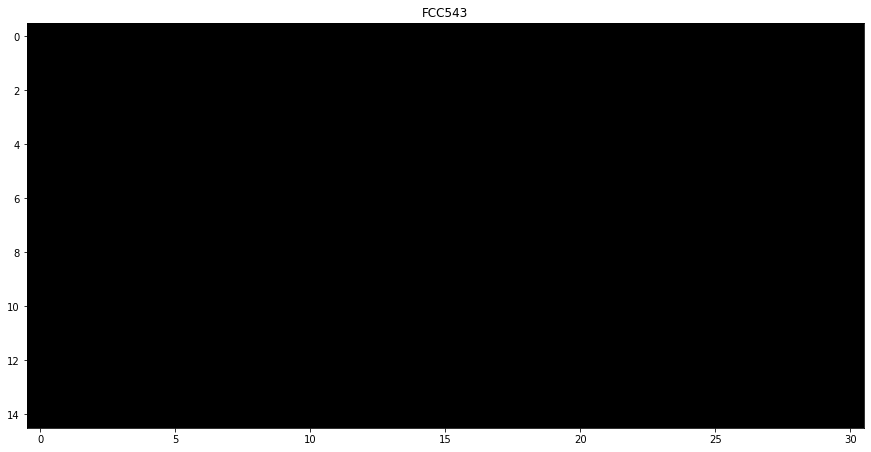

In [57]:
fig = plt.figure(figsize = (15,15))
plt.imshow(raster_fcc/32768)
plt.title('FCC543')

# Another methods for stacking 

In [63]:
delete_all_downloaded_files(DOWNLOADS_DIR)
delete_all_downloaded_files(MASKED_FILES_DIR)